# A1: Linear Regression for Car Price Prediction - Improved Pipeline
**Student ID: st126010 - Htut Ko Ko**

This notebook implements linear regression with proper data pipeline: split > impute > scale > train

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pickle

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the dataset
data = pd.read_csv('Cars.csv')
print(f"Dataset shape: {data.shape}")
print(f"Columns: {list(data.columns)}")
data.head()

Dataset shape: (8128, 13)
Columns: ['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque', 'seats']


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
# Basic data info
print("Dataset Info:")
data.info()
print("\nMissing values:")
print(data.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB

Missing values:
name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission

In [4]:
# Clean data - extract numeric values from string columns
data['mileage'] = data['mileage'].str.extract('(\\d+\\.?\\d*)').astype(float)
data['engine'] = data['engine'].str.extract('(\\d+)').astype(float)
data['max_power'] = data['max_power'].str.extract('(\\d+\\.?\\d*)').astype(float)

# Drop irrelevant columns
data = data.drop(columns=['name', 'torque'])

print("Data cleaning completed")
print(f"Shape after cleaning: {data.shape}")

Data cleaning completed
Shape after cleaning: (8128, 11)


In [5]:
# Define features and target
numeric_columns = ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats']
categorical_columns = ['fuel', 'seller_type', 'transmission', 'owner']
feature_names = numeric_columns + categorical_columns

X = data[feature_names].copy()
y = data['selling_price']

print(f"Features: {feature_names}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Missing values in features:")
print(X.isnull().sum())

Features: ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats', 'fuel', 'seller_type', 'transmission', 'owner']
X shape: (8128, 10)
y shape: (8128,)
Missing values in features:
year              0
km_driven         0
mileage         221
engine          221
max_power       216
seats           221
fuel              0
seller_type       0
transmission      0
owner             0
dtype: int64


In [6]:
# STEP 1: Split data FIRST (before any preprocessing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training missing values: {X_train.isnull().sum().sum()}")
print(f"Test missing values: {X_test.isnull().sum().sum()}")

Training set: (6502, 10)
Test set: (1626, 10)
Training missing values: 677
Test missing values: 202


In [7]:
# STEP 2: Impute missing values (fit on train, transform both)
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

# Impute numeric columns
X_train[numeric_columns] = imputer_num.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = imputer_num.transform(X_test[numeric_columns])

# Impute categorical columns
X_train[categorical_columns] = imputer_cat.fit_transform(X_train[categorical_columns])
X_test[categorical_columns] = imputer_cat.transform(X_test[categorical_columns])

print("✅ Missing values imputed")
print(f"Training missing values after imputation: {X_train.isnull().sum().sum()}")
print(f"Test missing values after imputation: {X_test.isnull().sum().sum()}")

✅ Missing values imputed
Training missing values after imputation: 0
Test missing values after imputation: 0


In [8]:
# STEP 3: Encode categorical variables (fit on train, transform both)
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

print("✅ Categorical variables encoded")
print(f"Label encoders created for: {list(label_encoders.keys())}")

✅ Categorical variables encoded
Label encoders created for: ['fuel', 'seller_type', 'transmission', 'owner']


In [9]:
# STEP 4: Scale features (fit on train, transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

✅ Features scaled
Scaled training set shape: (6502, 10)
Scaled test set shape: (1626, 10)


In [10]:
# STEP 5: Train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

print("✅ Model trained successfully")

✅ Model trained successfully


In [11]:
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"A1 Linear Regression Results (Proper Pipeline):")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

A1 Linear Regression Results (Proper Pipeline):
Training RMSE: 457730.36
Test RMSE: 453323.23
Training R²: 0.6770
Test R²: 0.6865


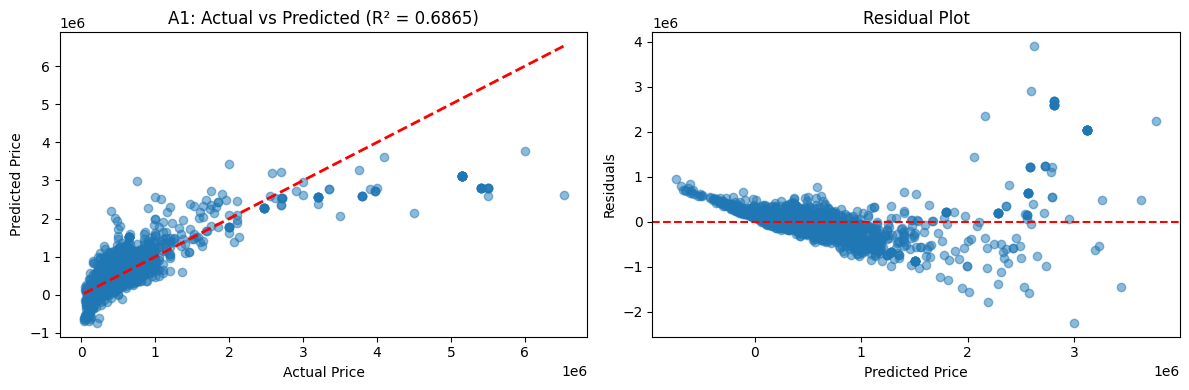

In [12]:
# Visualize results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'A1: Actual vs Predicted (R² = {test_r2:.4f})')

plt.subplot(1, 2, 2)
residuals = y_test - y_pred_test
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()

In [13]:
# Save model artifacts
model_artifacts = {
    'model': model,
    'scaler': scaler,
    'imputer_num': imputer_num,
    'imputer_cat': imputer_cat,
    'label_encoders': label_encoders,
    'feature_names': feature_names,
    'metrics': {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    }
}

with open('a1_model_artifacts.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("✅ Model artifacts saved as 'a1_model_artifacts.pkl'")
print(f"🎯 Final Test R²: {test_r2:.4f}")
print("🔄 Pipeline: Load → Clean → Split → Impute → Scale → Train → Evaluate")

✅ Model artifacts saved as 'a1_model_artifacts.pkl'
🎯 Final Test R²: 0.6865
🔄 Pipeline: Load → Clean → Split → Impute → Scale → Train → Evaluate
